In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from pytz import timezone
import requests
import time
from tqdm.auto import tqdm
from datetime import timedelta
import math

In [2]:
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor,  as_completed

In [3]:
tqdm.pandas()

In [4]:
api_key = "NahcgY5iZpJiLbXPYqZcgV6RatP09HUV"

In [120]:
def is_weekend(date_obj):
    is_saturday = date_obj.weekday() == 5  # Saturday
    is_sunday = date_obj.weekday() == 6    # Sunday
    return is_saturday or is_sunday
def get_difference(start_date, end_date, span):
    delta = end_date - start_date
    if span == 'day':
        days_difference = delta.days
        return days_difference
    elif span == 'minute':
        seconds_difference = delta.total_seconds()
        minutes_difference = seconds_difference / 60
        return minutes_difference
    elif span == 'second':
        seconds_difference = delta.total_seconds()
        return seconds_difference
    else:
        assert False, "Wrong span"
        
        
def get_query_strings(ticker, start_date, end_date, span, multiplier, prepost_market=False, limit = 30000, api_key="NahcgY5iZpJiLbXPYqZcgV6RatP09HUV"):
    if type(start_date) == str:
        start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    if type(end_date) == str:
        end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    if span == 'second':
        seconds_per_segment = 24 * 3600
    if span == 'minute':
        seconds_per_segment = 24 * 3600 * 30
    if span == 'day':
        seconds_per_segment = 24 * 3600 * 365
    difference = get_difference(start_date, end_date, "second")
    n_segment = int(difference // seconds_per_segment) + 1
    segments = [start_date + timedelta(seconds=i * seconds_per_segment) for i in range(n_segment + 1) if start_date + timedelta(seconds=i * seconds_per_segment) < end_date]
    segments.append(end_date+timedelta(days=1))
    querys = []
    for s, e in zip(segments[:-1], segments[1:]):
        if s.weekday() == 5 and (e-s).days <= 2:
            continue
        if s.weekday() == 6 and (e-s).days <= 1:
            continue
        from_date = s.strftime("%Y-%m-%d")
        to_date = (e-timedelta(days=1)).strftime("%Y-%m-%d")
        query = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{span}/{from_date}/{to_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}"
        querys.append(query)
    return querys
    

In [121]:
def post_request(query_string):
    try:
        res_df = pd.DataFrame().from_records(requests.get(query_string).json()['results'])
        res_df['datetime'] = res_df['t'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000, timezone('US/Eastern')).strftime('%Y-%m-%d-%H:%M:%S'))
        res_df['date'] = res_df['datetime'].apply(lambda x:'-'.join(x.split('-')[:3]))
        res_df['time'] = res_df['datetime'].apply(lambda x:'-'.join(x.split('-')[3:]))
        return res_df
    except requests.exceptions.RequestException as e:
        print(str(e))
    except KeyError as e2:
        print(str(e2), print(query_string))


In [125]:
from_date = "2021-03-04"
to_date = "2024-03-06"

In [126]:
querys = get_query_strings("AAPL", from_date, to_date, 'minute', 1)

In [127]:
results = []
with tqdm(total=len(querys)) as pbar:
    with ThreadPoolExecutor(max_workers=16) as ex:
        futures = [ex.submit(post_request, q) for q in querys]
        for future in as_completed(futures):
            result = future.result()
            results.append(result)
            pbar.update(1)

  0%|          | 0/37 [00:00<?, ?it/s]

In [50]:
res_df = pd.concat(results).sort_values(by='t', ascending=True).reset_index(drop=True)

In [93]:
res_df['vol_density'] = res_df.apply(lambda x:x['v'] * 1.0 / x['n'],axis=1)

In [94]:
window_size = 1000  # 10 days in seconds
res_df['vol_density_rolling_mean_100sample'] = res_df["vol_cdensity"].rolling(window=window_size).mean()
res_df['vol_density_rolling_std_100sample'] = res_df["vol_density"].rolling(window=window_size).std()

In [104]:
res_df["5_sigma"] = res_df.progress_apply(lambda x:(x['vol_density'] > x['vol_density_rolling_mean_100sample'] + 5 * x['vol_density_rolling_mean_100sample']) and (x['c']-x['o'])/x['c'] > 0.001,axis = 1)

  0%|          | 0/5514763 [00:00<?, ?it/s]

In [105]:
index_list = []
for i in list(res_df[res_df['5_sigma']].index):
    index_list+=list(range(i-10, i+10))
index_list = sorted(list(set(index_list)))

In [106]:
len(index_list)

969

In [107]:
list(res_df[res_df['5_sigma']].index)

[417240,
 458777,
 544734,
 692546,
 1198704,
 1421541,
 1599947,
 1771300,
 1792537,
 1792543,
 1892931,
 2080262,
 2101697,
 2101747,
 2291055,
 2472514,
 2472516,
 2472517,
 2493080,
 2493948,
 2602168,
 2820728,
 2821138,
 2844784,
 2844982,
 2891337,
 3074773,
 3140559,
 3595776,
 3616599,
 3616605,
 3702904,
 3706481,
 4031035,
 4187347,
 4295136,
 4314660,
 4314662,
 4662477,
 4752020,
 4921476,
 4943792,
 4943804,
 4943889,
 4966736,
 4969701,
 4997614,
 5161552,
 5183247,
 5184111,
 5186324,
 5248168,
 5371361]

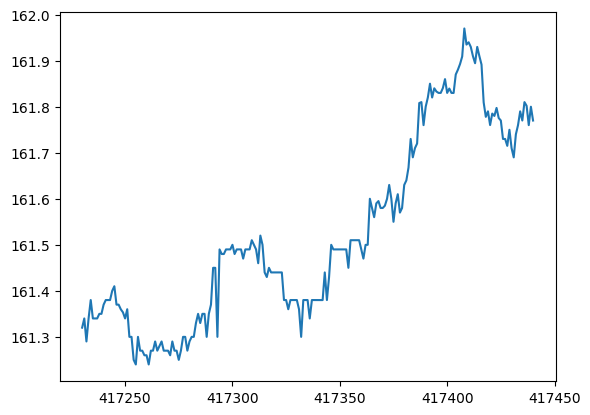

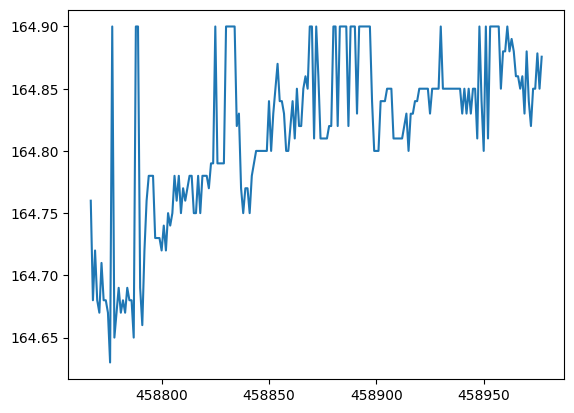

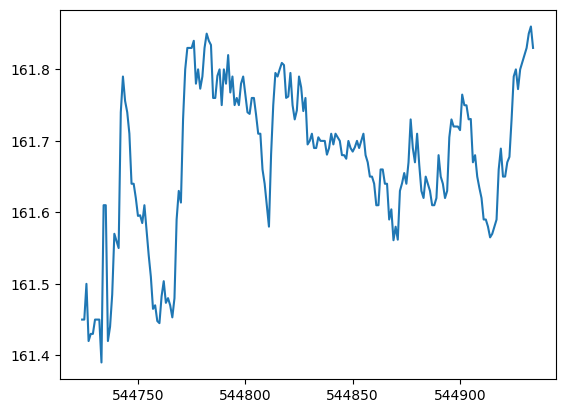

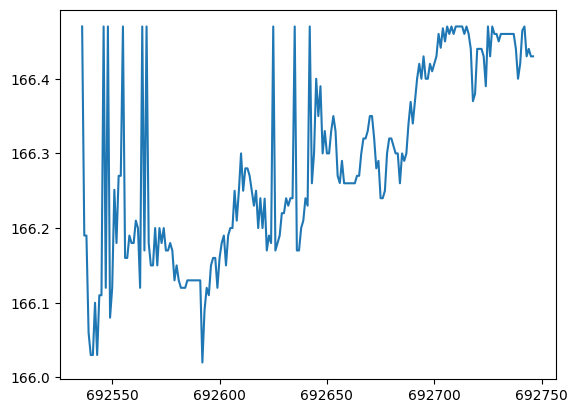

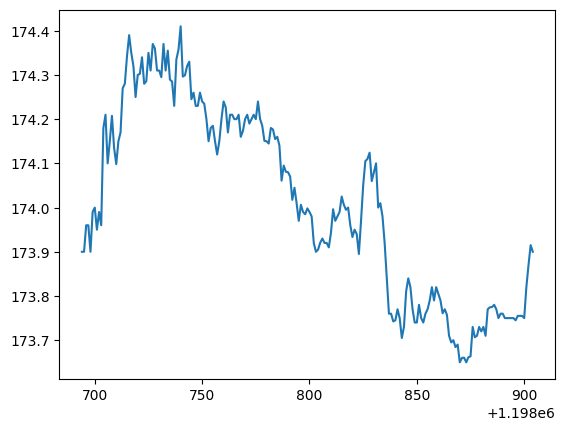

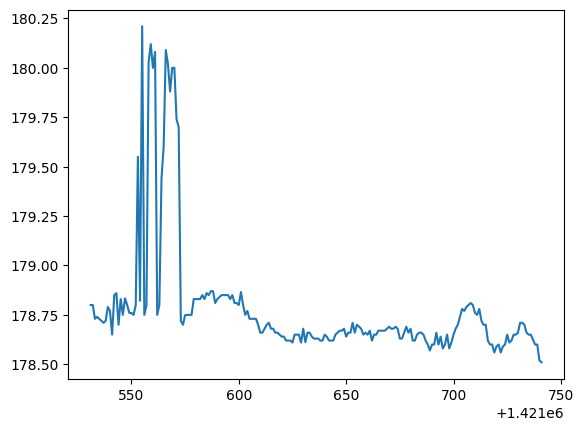

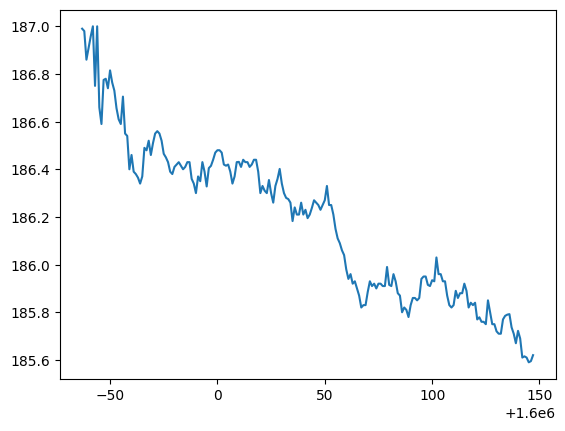

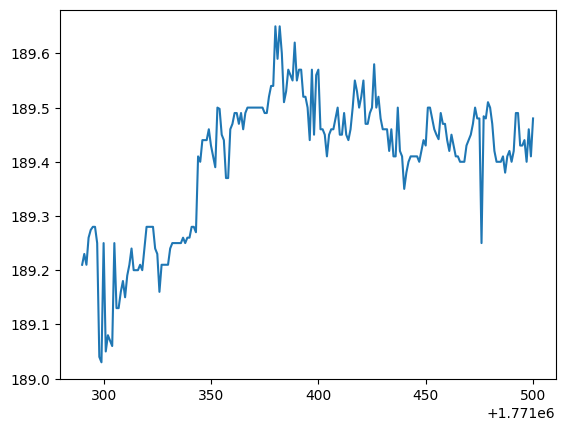

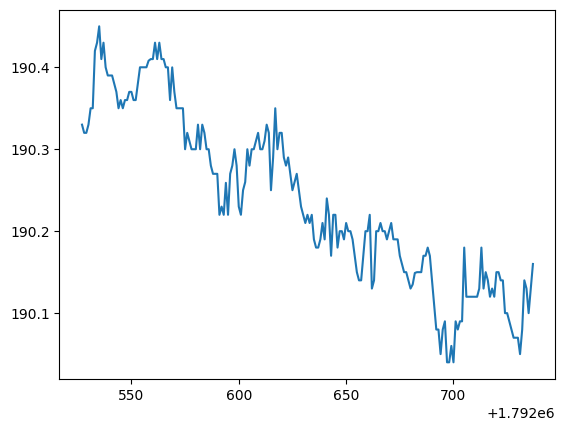

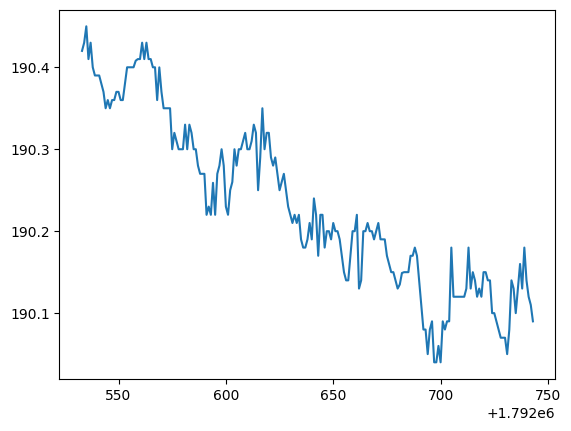

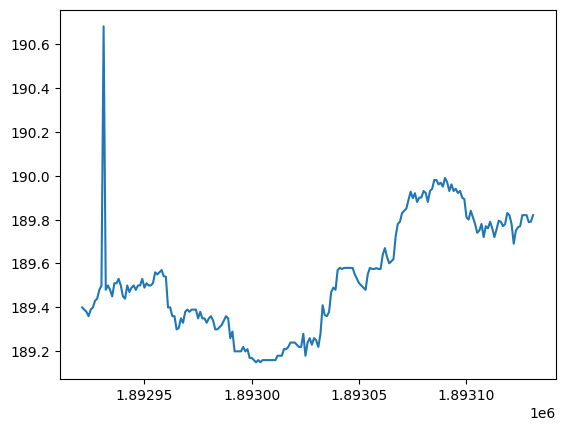

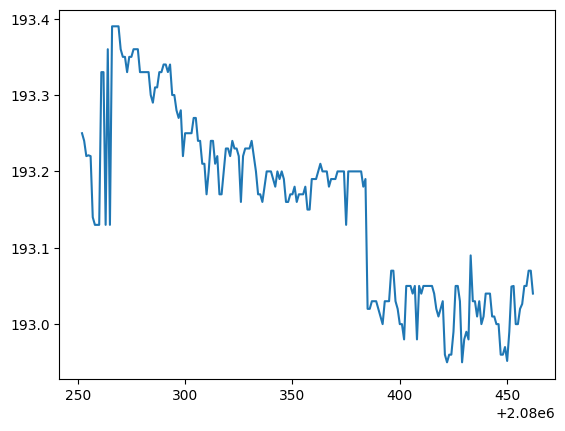

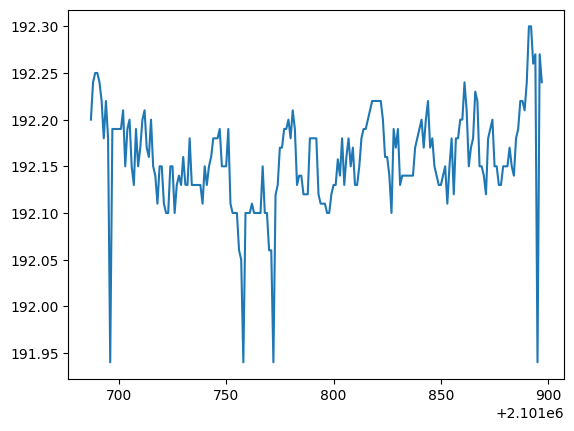

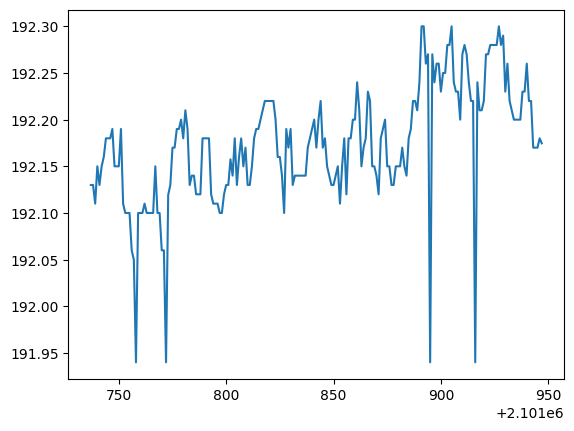

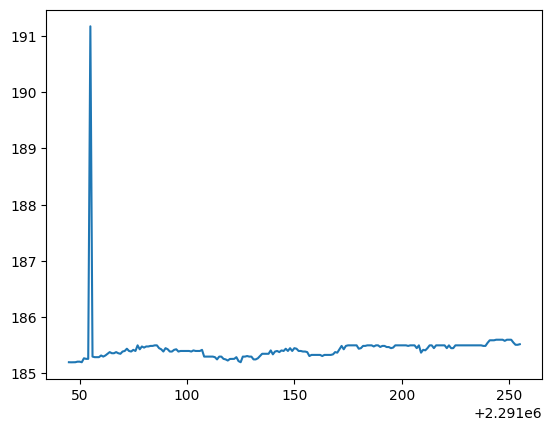

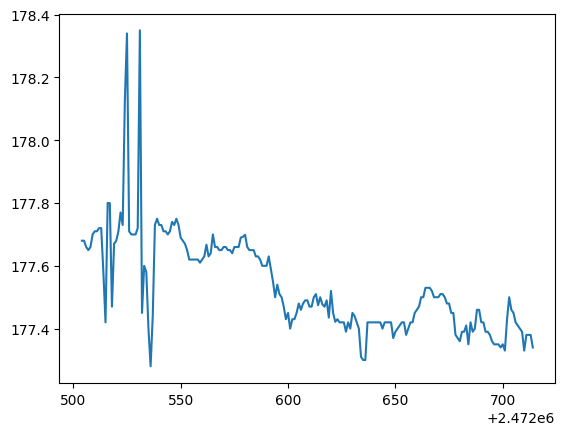

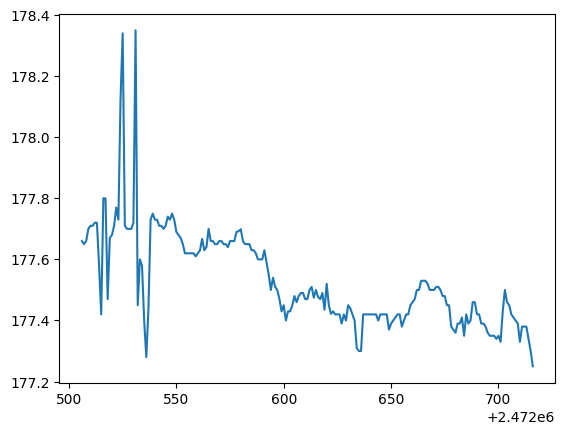

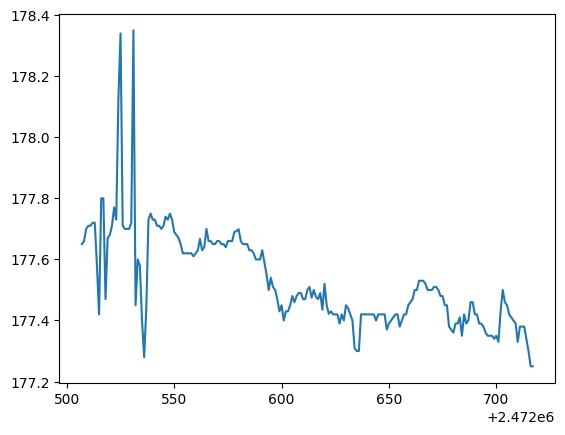

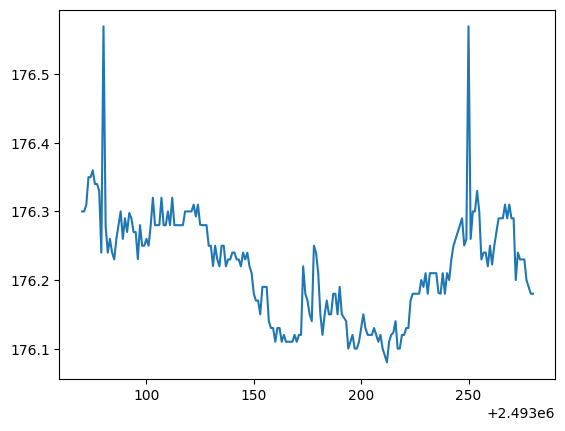

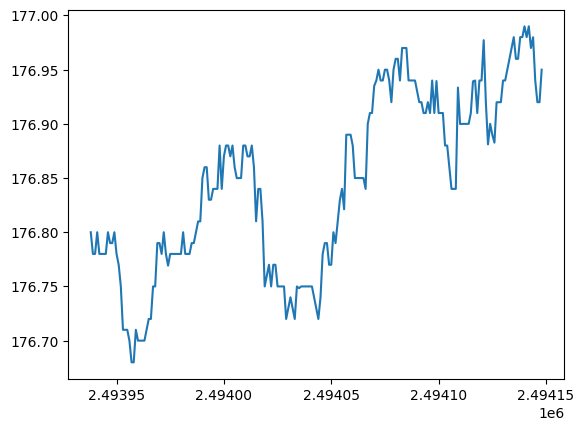

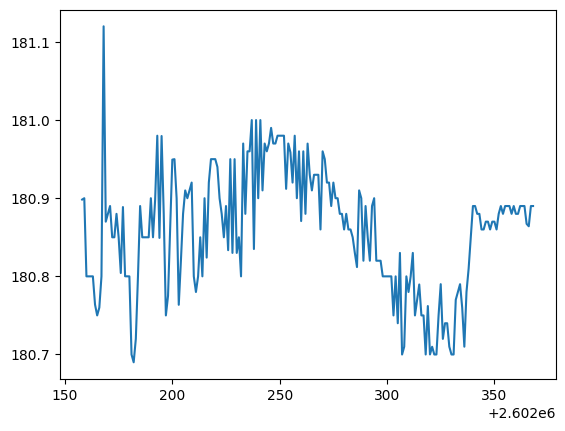

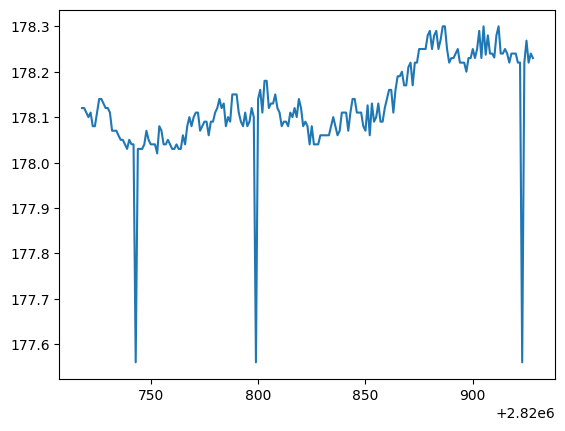

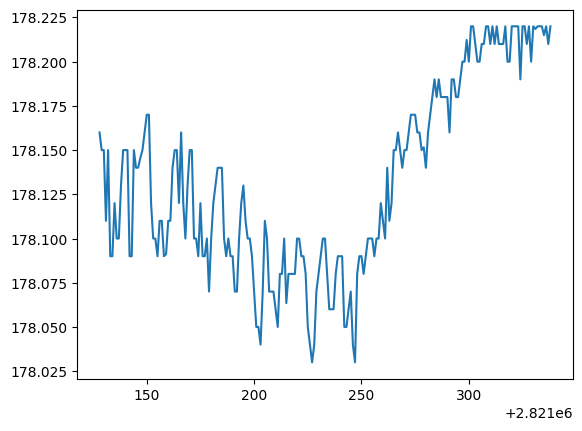

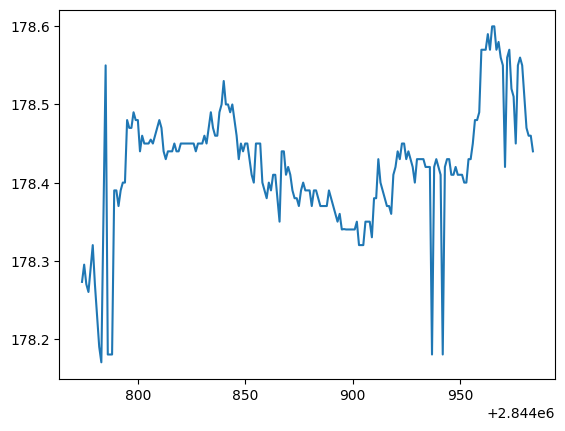

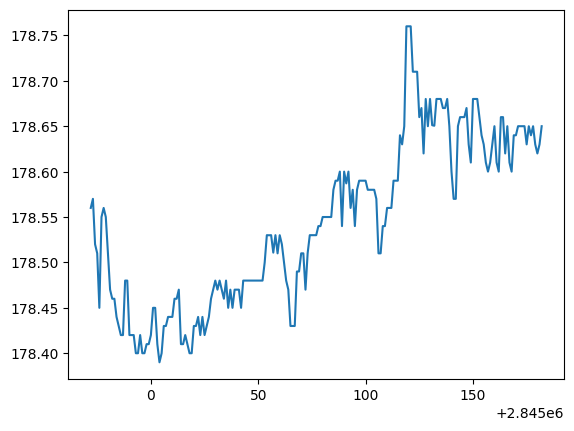

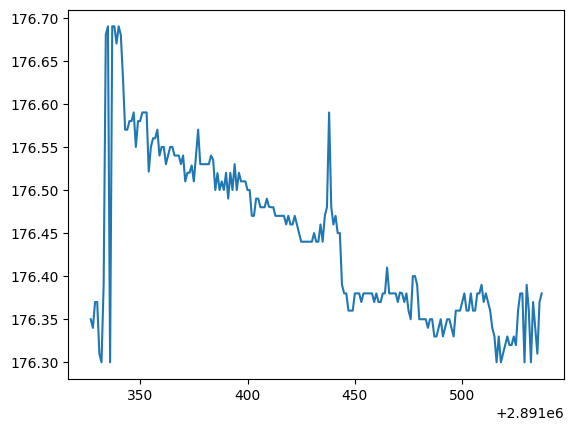

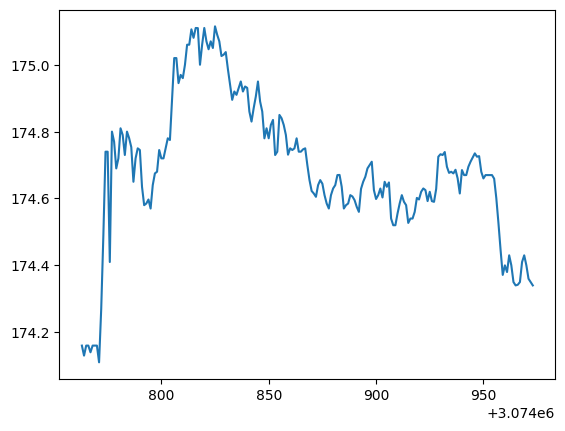

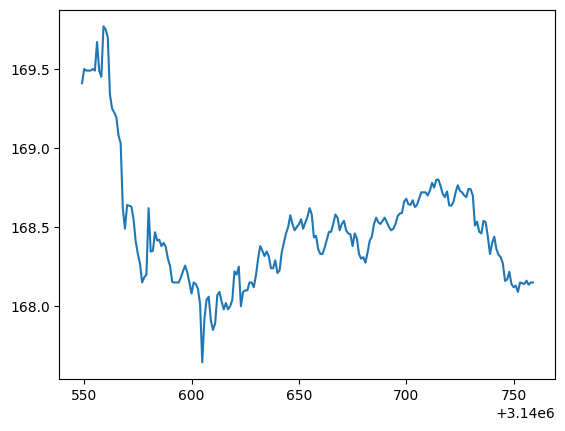

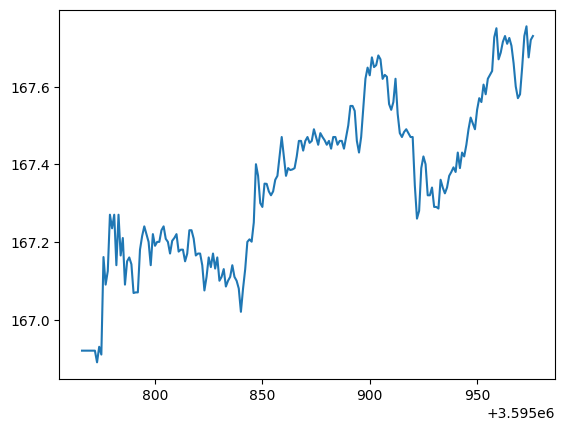

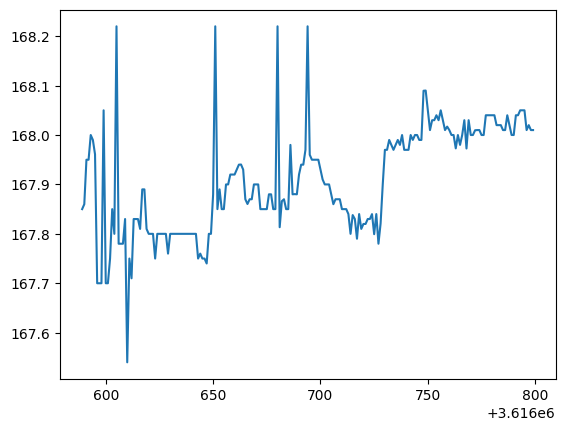

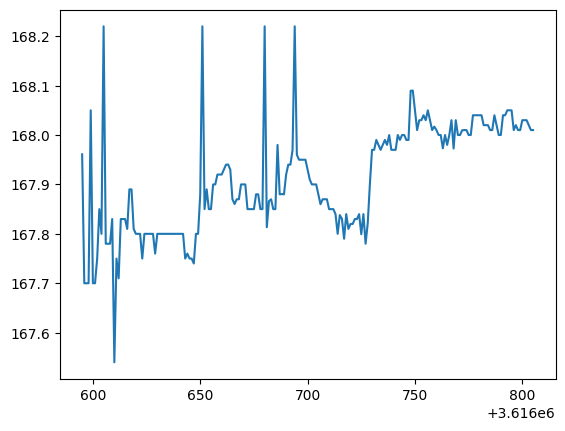

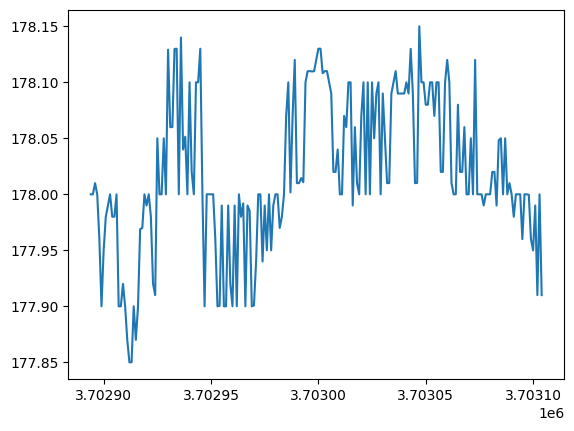

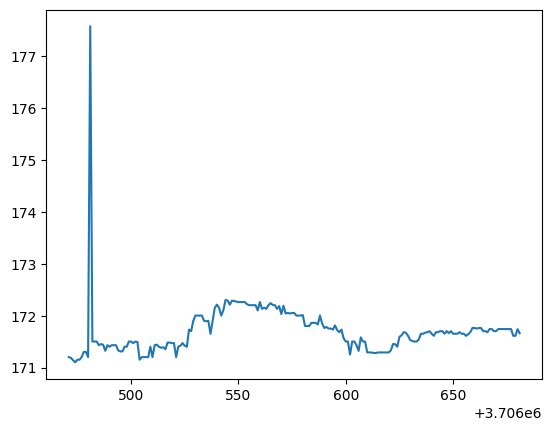

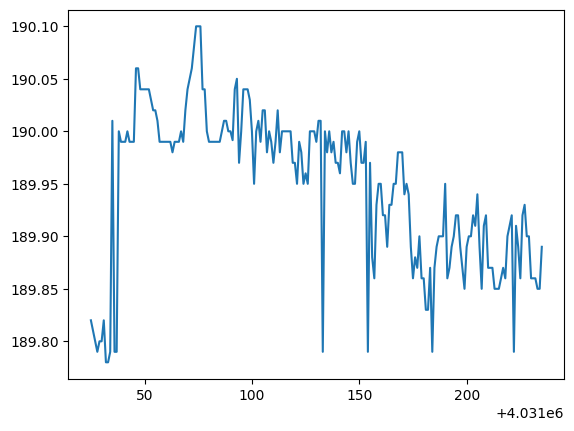

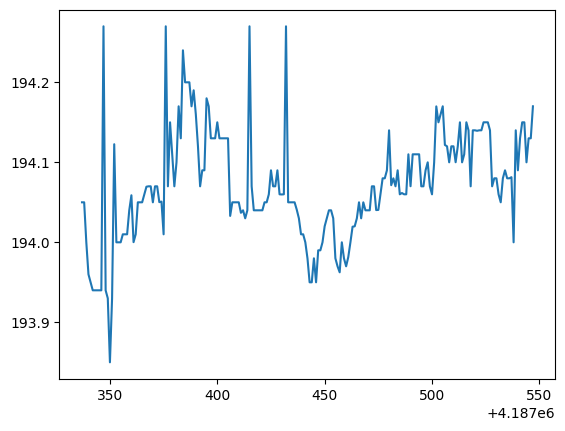

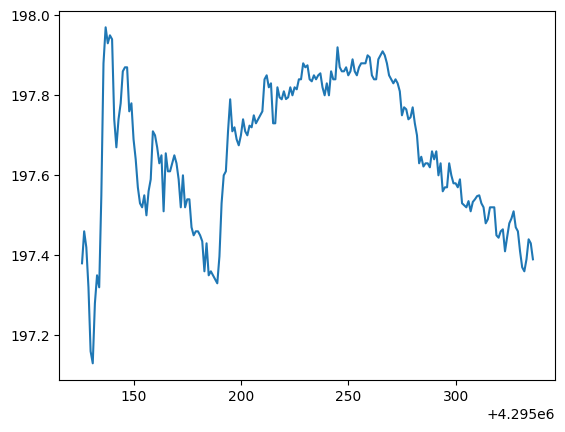

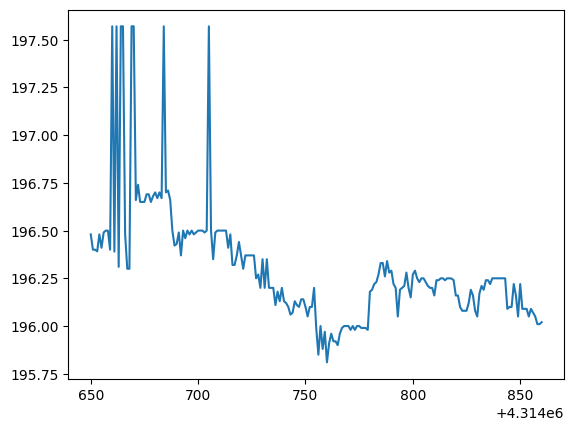

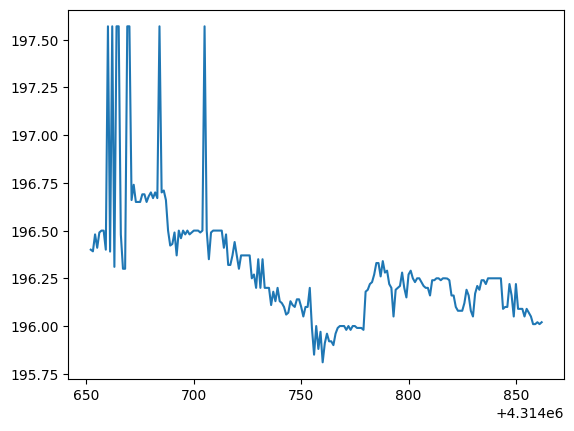

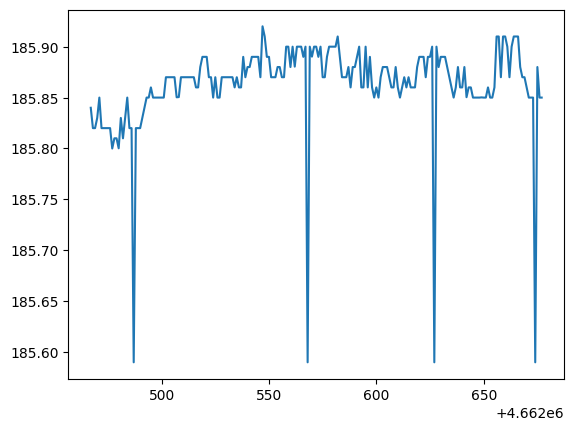

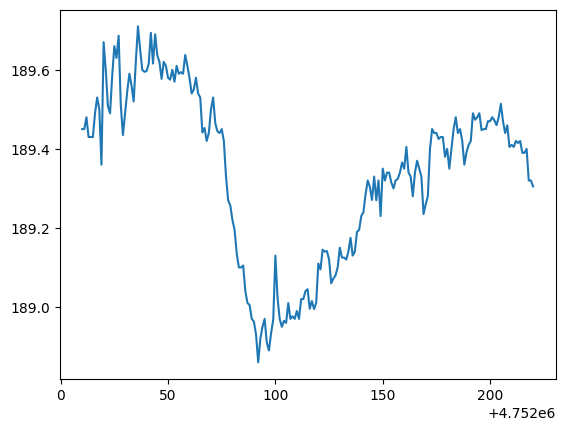

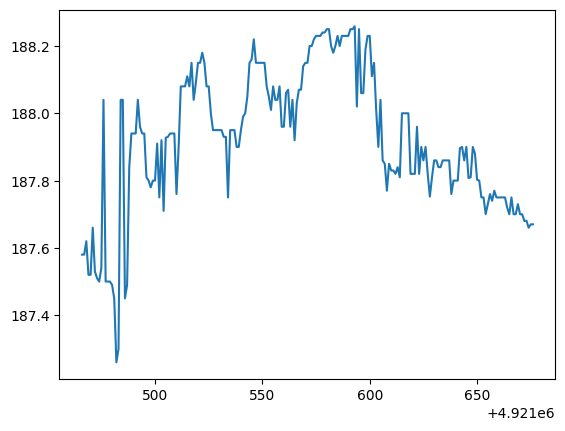

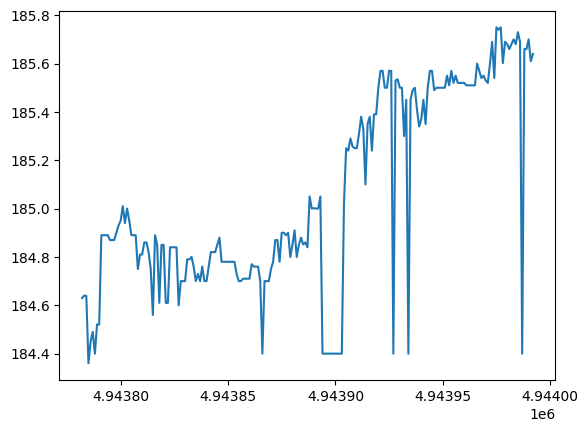

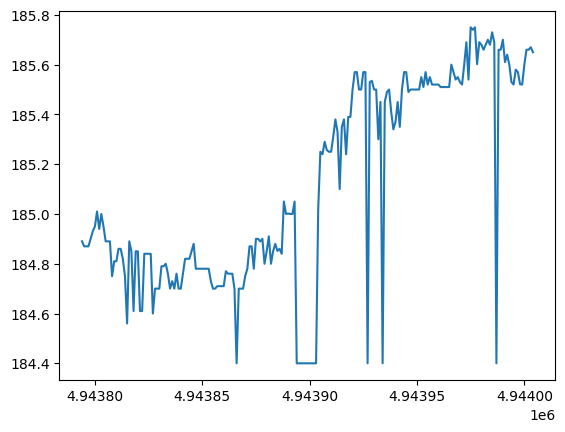

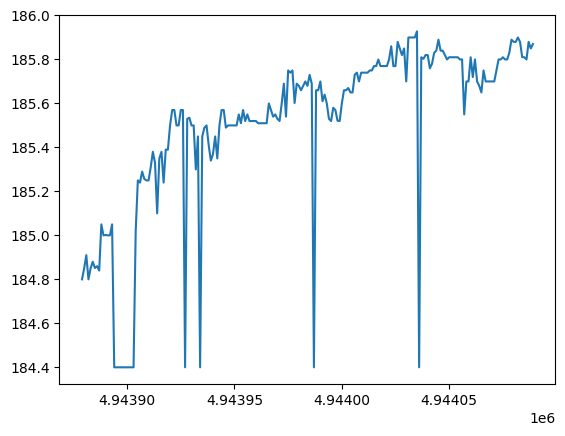

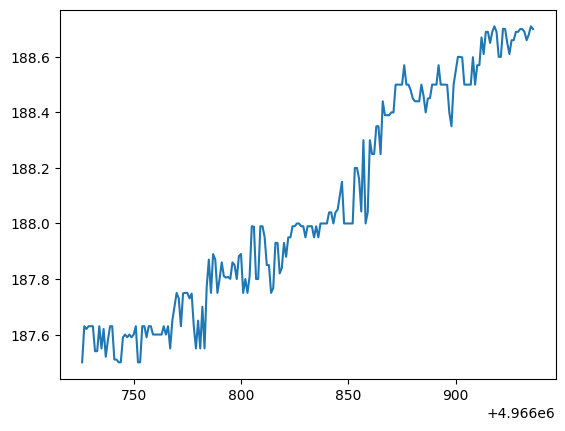

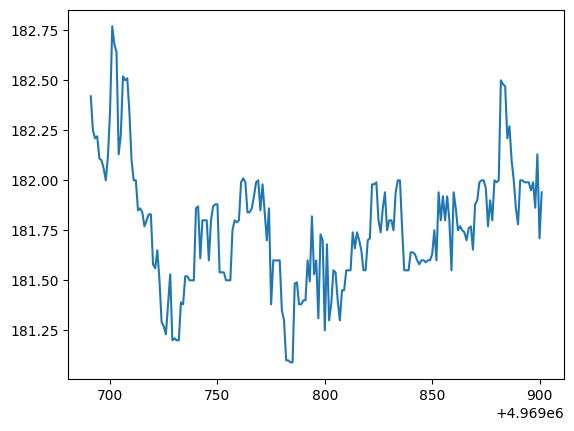

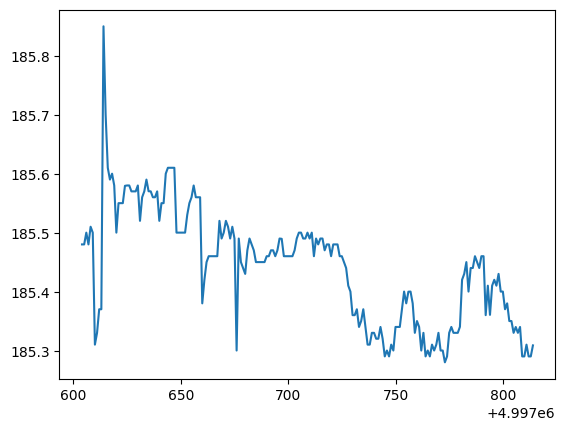

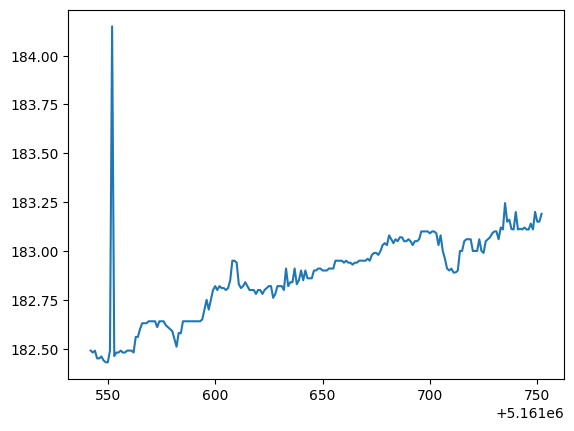

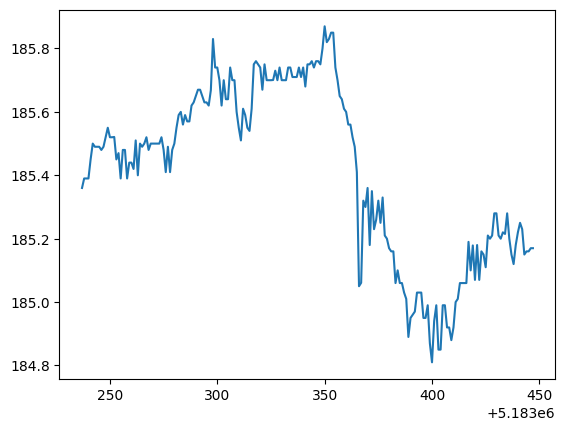

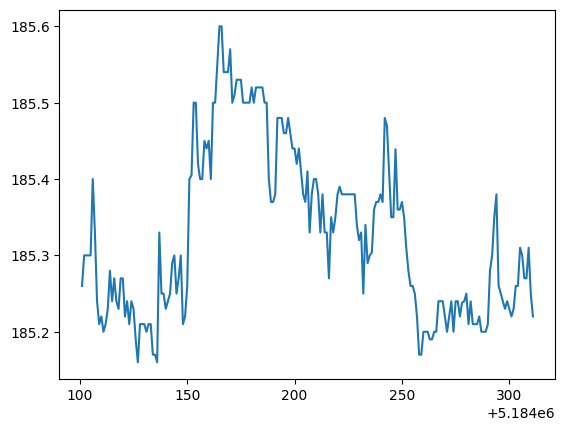

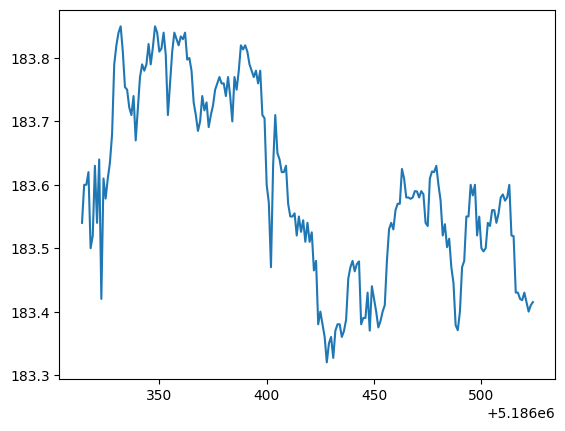

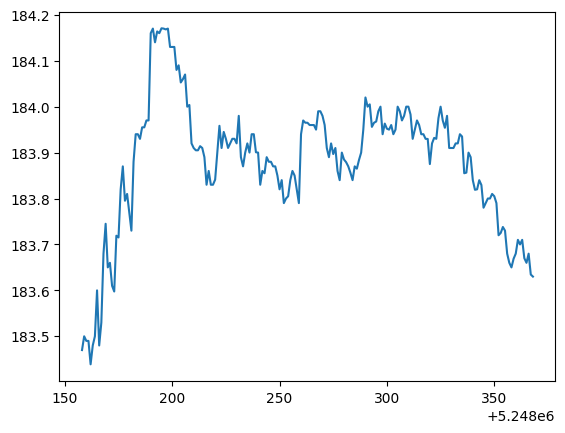

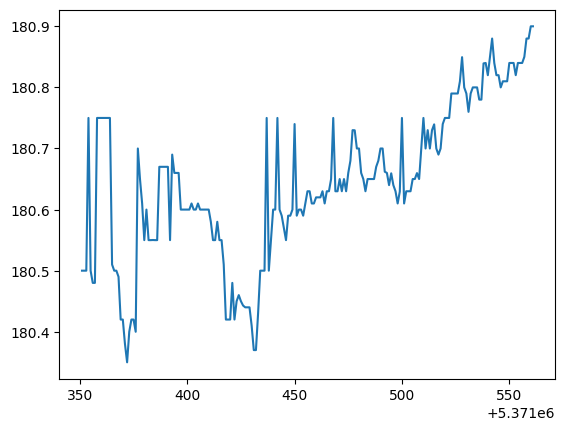

In [117]:
for index in list(res_df[res_df['5_sigma']].index):
    plt.plot(res_df.loc[index-10:index+200]["c"])
    plt.show()